In [2]:
import os
os.chdir(r'/content/drive/MyDrive/Work/PI_deepOnet_General/Allen_Cahn')
# os.chdir(r'C:\Users\Feliz\Desktop\jupyter\DeepOnet_General\Allen')
import torch
import torch.autograd as autograd
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.io
import math
import scipy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
import os
import csv
#from models import Green_transformer

class SimpleCSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath

        # If the file doesn't exist, create one with headers.
        if not os.path.exists(filepath):
            with open(filepath, 'w', newline='') as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(['epoch', 'metric', 'value'])

    def log(self, epoch, metric, value):
        with open(self.filepath, 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow([epoch, metric, value])

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Data = scipy.io.loadmat('Data.mat')

Input = torch.tensor(Data['AT'], dtype = torch.float32).to(device)
Output = torch.tensor(Data['UT'], dtype = torch.float32).to(device)

COOR = torch.tensor(Data['coors']).cuda()
coor  = COOR.repeat(len(Input),1,1).float()

coorx = coor[:,:,0][:,:,None]
coort = coor[:,:,1][:,:,None]

Input = Input[:,:,None]
Output = Output[:,:,None]

Yc = Output.squeeze()
Yc_mean = torch.mean(Yc,axis=0)
Yc = Yc - Yc_mean
n = len(Yc)
C = 1 / (n - 1) * Yc.T @ Yc
w, v = torch.linalg.eigh(C)
v = torch.fliplr(v)
v *= len(Yc_mean) ** 0.5
Bases = v[None,:,:]
Bases = Bases/torch.max(Bases)

Length = len(Input)

# torch.manual_seed(0)
# np.random.seed(0)


OutOfMemoryError: CUDA out of memory. Tried to allocate 10.06 GiB. GPU 0 has a total capacity of 15.77 GiB of which 4.73 GiB is free. Process 18825 has 11.04 GiB memory in use. Of the allocated memory 8.95 GiB is allocated by PyTorch, and 1.69 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
batch_size = 16

x_data = Input
cx_data = coorx
ct_data = coort
y_data = Output

x_train = x_data[0:int(0.8*Length),:,:]
cx_train = cx_data[0:int(0.8*Length),:,:]
ct_train = ct_data[0:int(0.8*Length),:,:]
y_train = y_data[0:int(0.8*Length),:,:]

x_val = x_data[int(0.6*Length):int(0.8*Length),:,:]
cx_val = cx_data[int(0.6*Length):int(0.8*Length),:,:]
ct_val = ct_data[int(0.6*Length):int(0.8*Length),:,:]
y_val = y_data[int(0.6*Length):int(0.8*Length),:,:]

x_test = x_data[int(0.8*Length):Length,:,:]
cx_test = cx_data[int(0.8*Length):Length,:,:]
ct_test = ct_data[int(0.8*Length):Length,:,:]
y_test = y_data[int(0.8*Length):Length,:,:]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, cx_train, ct_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val, cx_val, ct_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, cx_test, ct_test, y_test), batch_size=batch_size, shuffle=False)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
class MLP1(nn.Module):
    def __init__(self,width_trunk, width_branch, length):
        super().__init__()
        layers = np.array([length,width_branch,width_branch,width_branch,width_branch,width_trunk])
        self.linears = torch.nn.Sequential(nn.Linear(layers[0],layers[1]), torch.nn.ReLU(),
                                           nn.Linear(layers[1],layers[2]), torch.nn.ReLU(),
                                           nn.Linear(layers[2],layers[3]), torch.nn.ReLU(),
                                           nn.Linear(layers[3],layers[4]), torch.nn.ReLU(),
                                           nn.Linear(layers[4],layers[5]))

    def forward(self,x):
        y = self.linears(x)
        return y

class MLP2(nn.Module):
    def __init__(self,width_trunk, width_branch, length):
        super().__init__()
        layers = np.array([length,width_branch,width_branch,width_branch,width_branch,width_trunk])
        self.linears = torch.nn.Sequential(nn.Linear(layers[0],layers[1]), torch.nn.ReLU(),
                                           nn.Linear(layers[1],layers[2]), torch.nn.ReLU(),
                                           nn.Linear(layers[2],layers[3]), torch.nn.ReLU(),
                                           nn.Linear(layers[3],layers[4]), torch.nn.ReLU(),
                                           nn.Linear(layers[4],layers[5]))

    def forward(self,x):
        y = self.linears(x)
        return y

class DeepOnet(nn.Module):
    def __init__(self, width_trunk, width_branch, length):
        super(DeepOnet, self).__init__()

        self.encoder = nn.Linear(2, width_trunk) # input channel is 2: (a(x), x)
        self.w1 = torch.nn.Linear(width_trunk, width_trunk)
        self.w2 = torch.nn.Linear(width_trunk, width_trunk)
        self.w3 = torch.nn.Linear(width_trunk, width_trunk)
        self.w4 = torch.nn.Linear(width_trunk, width_trunk)
        self.MLP = MLP1(width_trunk, width_branch, length)

    def forward(self, x, cx, ct):
        x = x.repeat(1,1,cx.size(1)).permute(0,2,1)
        # print(x[0,:,:])
        # print(jj)
        x1 = self.MLP(x)

        c = torch.cat((cx,ct),dim=2)
        c = self.encoder(c)
        c = F.gelu(c)
        c = self.w1(c)
        c = F.gelu(c)
        c = self.w2(c)
        c = F.gelu(c)
        c = self.w3(c)
        c = F.gelu(c)
        c = self.w4(c)
        c = F.gelu(c)
        c = c*x1

        y = torch.sum(c,2)

        return y

class POD_DeepOnet(nn.Module):
    def __init__(self, width_trunk, width_branch, length, basis):
        super(POD_DeepOnet, self).__init__()

        self.encoder = nn.Linear(2, width_trunk) # input channel is 2: (a(x), x)
        self.B = basis[:,:,:width_trunk]
        self.w1 = torch.nn.Linear(width_trunk, width_trunk)
        self.w2 = torch.nn.Linear(width_trunk, width_trunk)
        self.w3 = torch.nn.Linear(width_trunk, width_trunk)
        self.w4 = torch.nn.Linear(width_trunk, width_trunk)
        self.MLP = MLP1(width_trunk, width_branch, length)

    def forward(self, x, cx, cy):
        x = x.repeat(1,1,cx.size(1)).permute(0,2,1)
        # print(x.size())
        x1 = self.MLP(x)

        B = self.B.repeat(x.size(0),1,1)
        c = torch.cat((cx,cy),dim=2)

        c = B*x1

        y = torch.sum(c,2)

        return y


In [ ]:
model = POD_DeepOnet(width_trunk = 128, width_branch = 128, length = 100, basis = Bases).to(device, dtype = torch.float32)
print(count_parameters(model))
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
num_epochs = 500

Rec = []

best_loss = np.inf
patience_counter=0
best_weights = None
patience = 300

for ep in range(num_epochs):
    model.train()
    t1 = default_timer()
    De_mse = 0
    train_l2 = 0
    Re_mse = 0
    Be_mse = 0
    ne = 0
    nt = 0
    for x, cx, ct, y in train_loader:
        ne += 1
        x, cx, ct, y = x.cuda(), cx.cuda(), ct.cuda(), y.cuda()

        optimizer.zero_grad()
        # cx.requires_grad = True
        # ct.requires_grad = True
        out = model(x,cx,ct)
        # dsdx = autograd.grad(out,cx,torch.ones_like(out).to(device),retain_graph=True,create_graph=True)[0]
        # dsdxdx = autograd.grad(dsdx,cx,torch.ones_like(dsdx).to(device),retain_graph=True,create_graph=True)[0]
        # dsdt = autograd.grad(out,ct,torch.ones_like(out).to(device),retain_graph=True,create_graph=True)[0]

        # pde = dsdt + out[:,:,None]*dsdx - 0.001*dsdxdx

        De = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        # Re = F.mse_loss(pde, torch.zeros_like(pde))*1e-3

        mse = De #+ Re

        mse.backward() # use the l2 relative loss
        optimizer.step()

        # Be_mse += Be.item()
        De_mse += De.item()
        # Re_mse += Re.item()

    scheduler.step()
    model.eval()
    test_mse = 0.0
    with torch.no_grad():
        for x, cx, ct, y in test_loader:
            nt += 1
            x, cx, ct, y = x.cuda(), cx.cuda(), ct.cuda(), y.cuda()

            out = model(x,cx,ct)
            test_mse += F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    De_mse /= ne
    Re_mse /= ne
    Be_mse /= ne
    test_mse /= nt

    t2 = default_timer()
    print(ep, t2-t1, De_mse, Re_mse, Be_mse, test_mse)
#%%
    recording = [t2-t1, De_mse, Re_mse, Be_mse, test_mse]
    Rec.append(recording)


145408
0 354.2163147000001 0.1933367064446211 0.0 0.0 0.10693190530652091
1 351.0099777999999 0.061257450565695766 0.0 0.0 0.039505391071240105
2 350.9947595000003 0.03544352899491787 0.0 0.0 0.032560386650619055
3 350.97287439999945 0.030031342796981334 0.0 0.0 0.02838917449116707
4 351.08832359999997 0.026463672518730164 0.0 0.0 0.025061102554438604
5 351.06160830000044 0.023952511213719843 0.0 0.0 0.022628045833063503
6 351.09710819999964 0.022195144467055797 0.0 0.0 0.021545701201946016
7 351.1729927000006 0.021086518049240114 0.0 0.0 0.02056765810601295
8 351.12697500000013 0.020302686251699925 0.0 0.0 0.019950990254680317
9 351.14618020000034 0.019657401494681835 0.0 0.0 0.01938042159946192
10 351.1736100999997 0.01921714501082897 0.0 0.0 0.01892095212898557
11 351.1863344000003 0.018790232360363007 0.0 0.0 0.018539300868435513
12 351.0644305000005 0.018515037022531034 0.0 0.0 0.018325558287047204
13 351.18957189999946 0.018265694104135036 0.0 0.0 0.018149119432246875
14 351.1937

KeyboardInterrupt: 

In [ ]:
mdic1 = {'Rec':Rec}
scipy.io.savemat(r'Dp_POD_training.mat',mdic1)
# scipy.io.savemat(r'Recoding/PI_Dp_gelu_training.mat',mdic1)
# scipy.io.savemat(r'Recoding/EDp_gelu_training.mat',mdic1)
# scipy.io.savemat(r'Recoding/PI_EDp_gelu_training.mat',mdic1)

torch.save(model, 'Dp_POD_model')

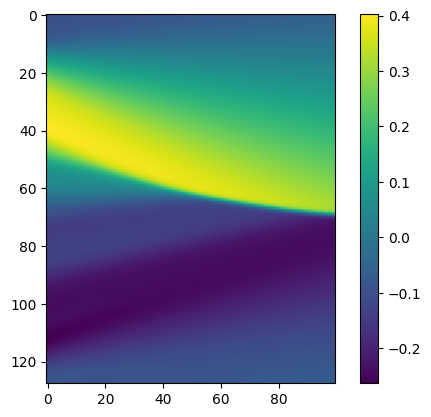

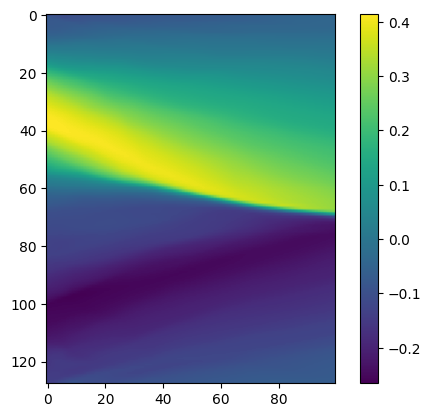

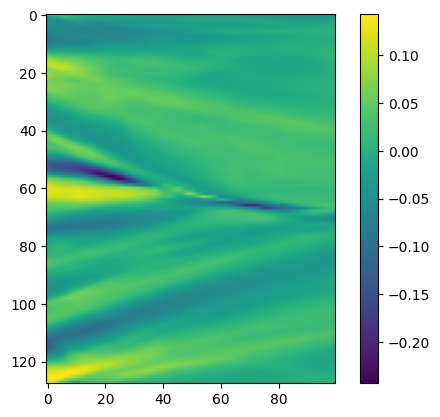

In [ ]:
k = 0
x = x_test[k,:,:][None,:,:].cuda()
cx = cx_test[k,:,:][None,:,:].cuda()
ct = ct_test[k,:,:][None,:,:].cuda()
y = y_test[k,:,:][None,:,:].cuda()
# x = torch.ones(1,n,1).cuda() + 10
out = model(x,cx,ct).squeeze().cpu()

yt = y.squeeze().cpu()
yt = y.squeeze().cpu()
yp = out.squeeze().cpu()
num = int((len(yt))**0.5)

yt = torch.reshape(yt,(128,100))
yp = torch.reshape(yp,(128,100))

plt.figure(1)
plt.imshow(yt)
plt.colorbar()
plt.figure(2)
plt.imshow(yp.detach().numpy())
plt.colorbar()
plt.figure(3)
plt.imshow((yt-yp.detach().numpy())/torch.max(abs(yt)))
plt.colorbar()